<a href="https://colab.research.google.com/github/rakesh4real/APACHE-KAFKA/blob/main/consumers_kafka_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Note:** Do **NOT** click `Run All` .Make sure you add addresses in config files as specified **every time** you run this notebook!

# Install Libraries

In [ ]:
!pip install kafka-python
!pip install Faker

     |████████████████████████████████| 256kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 2.7MB/s 


In [ ]:
from google.colab.output import serve_kernel_port_as_window as expose

# 1. Install Kafka and Zookeeper

Download `tgz` file and follow instructions [here](https://kafka.apache.org/quickstart)

In [ ]:
!curl -O https://mirrors.estointernet.in/apache/kafka/2.6.0/kafka_2.13-2.6.0.tgz
!tar -xzf kafka_2.13-2.6.0.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62.5M  100 62.5M    0     0  6286k      0  0:00:10  0:00:10 --:--:-- 9745k


`server.properties` for all brokers' and ` zookeeper.properties` for management and sync

**`server.properties`:** (At correct location)

```
advertised.listeners=PLAINTEXT://localhost:9092
.
.
zookeeper.connect=localhost:2181
```

**Note:** Start Zookeeper first

In [ ]:
!cd kafka_2.13-2.6.0 && bin/zookeeper-server-start.sh -daemon config/zookeeper.properties
!cd kafka_2.13-2.6.0 && JMX_PORT=8004 bin/kafka-server-start.sh -daemon config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


The two java processes correspond to zookeeper and the kafka instances.

In [ ]:
!ps -ef | grep kafka

root         489       1 16 02:03 ?        00:00:02 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-2.6.0/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=102400 -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-2.6.0/bin/../logs -Dlog4j.configuration=file:bin/../config/log4j.properties -cp /content/kafka_2.13-2.6.0/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-2.6.0/bin/../libs/aopalliance-repackaged-2.5.0.jar:/content/kafka_2.13-2.6.0/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-2.6.0/bin/../libs/audience-annotations-0.5.0.jar:/content/kafka_2.13-2.6.0/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-2.6.0/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.13-2.6.0/bin/../lib

# 2. Setup Kafka Manager

Make sure of java 8+ 

In [ ]:
!java --version

openjdk 11.0.9 2020-10-20
OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)


Below command will create `target` folder upon successful compilation

In [ ]:
!git clone https://github.com/yahoo/CMAK
!cd CMAK && ./sbt clean dist 

Cloning into 'CMAK'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 6272 (delta 0), reused 0 (delta 0), pack-reused 6271
Receiving objects: 100% (6272/6272), 3.84 MiB | 22.49 MiB/s, done.
Resolving deltas: 100% (4060/4060), done.
  From  https://repo.scala-sbt.org/scalasbt/maven-releases/org/scala-sbt/sbt-launch/1.3.8/sbt-launch-1.3.8.jar
    To  /root/.sbt/launchers/1.3.8/sbt-launch.jar
  From  https://repo.scala-sbt.org/scalasbt/maven-releases/org/scala-sbt/sbt-launch/1.3.8/sbt-launch-1.3.8.jar.md5
    To  /root/.sbt/launchers/1.3.8/sbt-launch.jar.md5
/root/.sbt/launchers/1.3.8/sbt-launch.jar: OK
[info] [launcher] getting org.scala-sbt sbt 1.3.8  (this may take some time)...
downloading https://repo1.maven.org/maven2/org/scala-sbt/sbt/1.3.8/sbt-1.3.8.jar ...
downloading https://repo1.maven.org/maven2/org/scala-lang/scala-library/2.12.10/scala-library-2.12.10.jar ...
:: loading settings :: url = jar:file:/root/.sbt/launchers/1.3.8/sbt

In [ ]:
%cd CMAK/target/universal
!unzip cmak-3.0.0.5.zip
%cd cmak-3.0.0.5

/content/CMAK/target/universal
Archive:  cmak-3.0.0.5.zip
  inflating: cmak-3.0.0.5/lib/cmak.cmak-3.0.0.5-sans-externalized.jar  
  inflating: cmak-3.0.0.5/lib/org.apache.commons.commons-lang3-3.6.jar  
  inflating: cmak-3.0.0.5/lib/org.apache.kafka.kafka-clients-2.4.1.jar  
  inflating: cmak-3.0.0.5/lib/javax.inject.javax.inject-1.jar  
  inflating: cmak-3.0.0.5/lib/com.fasterxml.jackson.core.jackson-core-2.10.0.jar  
  inflating: cmak-3.0.0.5/lib/com.fasterxml.jackson.datatype.jackson-datatype-jsr310-2.8.11.jar  
  inflating: cmak-3.0.0.5/lib/org.scalaz.scalaz-core_2.12-7.2.27.jar  
  inflating: cmak-3.0.0.5/lib/com.typesafe.play.play_2.12-2.6.21.jar  
  inflating: cmak-3.0.0.5/lib/io.netty.netty-codec-4.1.45.Final.jar  
  inflating: cmak-3.0.0.5/lib/com.yammer.metrics.metrics-core-2.2.0.jar  
  inflating: cmak-3.0.0.5/lib/com.fasterxml.jackson.datatype.jackson-datatype-jdk8-2.10.0.jar  
  inflating: cmak-3.0.0.5/lib/org.webjars.requirejs-2.3.5.jar  
  inflating: cmak-3.0.0.5/lib/org

Add `<zookeerper-host-addr>:port` in `application.conf`:
```
#cmak.zkhosts="kafka-manager-zookeeper:2181"
cmak.zkhosts="localhost:2181"
```

In [ ]:
expose(8081)

<IPython.core.display.Javascript object>

### **Click on the above link 👆 (will not load anything) and run the below 👇 cell. Refresh the page; You will see manager running!**

In [ ]:
"""
Launch manager
"""

!nohup bin/cmak -Dconfig.file=conf/application.conf -Dhttp.port=8081 &

nohup: appending output to 'nohup.out'


# Create new cluster

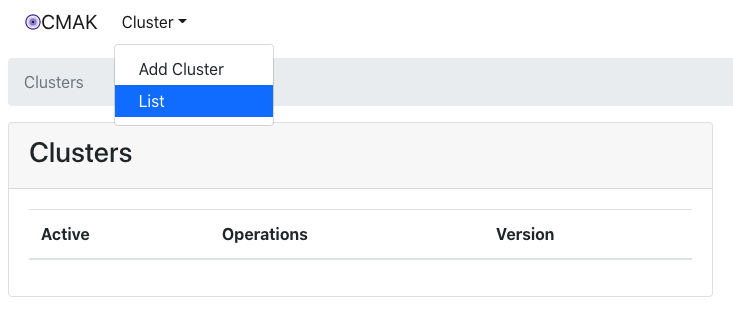

- **Cluster Name:** Give camelCased name. Eg, `TestCluster`
- **Cluster Zookeeper Hosts:** Coma separated addrs w/ ports (if multiple zookeepers) single address w/ port (if single zookeeper). Eg, `localhost:2181`
- [x] Enable JMX Polling (Set JMX_PORT env variable before starting kafka server)
- [x] Poll consumer information (Not recommended for large # of consumers if ZK is used for offsets tracking on older Kafka versions) -- To see how consumer is performing


**Leave others w/ default values** and click on `Save`

### ⭐️ To see the details about created clusters' `Brokers` (or) `Topics` click on the **number** adjacent to them

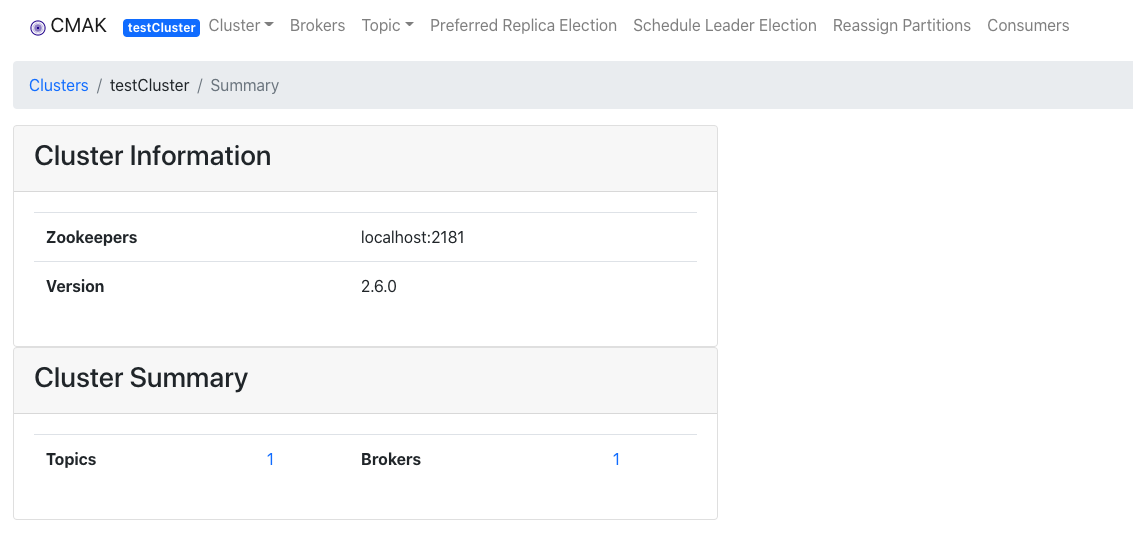

**Note:** You can Modify/Remove created clusters or add more clusters!


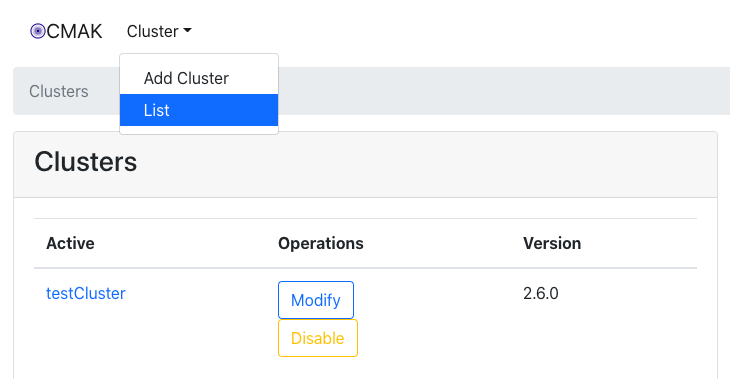

&nbsp;

----

<div style="text-align: center"> end of section </div>

----

&nbsp;

&nbsp;

In [33]:
"""
run producer in bg
"""

# consumer will not run unless producer publishes some data
# inside topic partion



from faker import Faker
fake = Faker()
 
def get_new_reg_user():
  return {
      "name": fake.name(),
      "addr": fake.address(),  
      "bio" : fake.text()    
  } 


import time
import json
from kafka import KafkaProducer
from data_source import get_new_reg_user
 
# serializer
def json_serializer(data):
  return json.dumps(data).encode(utf-8)
 
# instantiate producer
producer = KafkaProducer(
    bootstrap_servers="localhost:9092",
    value_serializer=json_serializer # takes `data` as input
    )
 
# send data
while True: 
  data_to_publish = get_new_reg_user()
  print("sending: ", data_to_publish)
 
  producer.send(
      topic=reg_users,
      value=data_to_publish
  )
 
  time.sleep(3)

NameError: ignored

# **Consumer in Python**

- Consumer group must be assigned to a consumer (randomly given if not assigned). Consumer groups are important for scalability!
- Consumers consume from topic *partitions*
- Consumers run independantly as a separate process
- Consumers from same group can be on different nodes
- Consumer runs only if producer is running and publishing data

## **Case 1:** 1 Topic, 1 Partition, 1 Consumer


**Note:** The instantiated consumer will directly start consuming messages. No method such as `subscribe` (or) `receive` must be used.

In [ ]:
"""
consumer
"""

from kafka import KafkaConsumer
import json


# define consumer and start consuming
consumer = KafkaConsumer(
    "reg_users",
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest', # 'earliest': oldest available message, 'latest': most recent
    group_id='consumer-group-0'
)

# log consumed messages
for msg in consumer:
  print('read: ', json.loads(msg.value))

KeyboardInterrupt: ignored